In [15]:
!pip install lifelines 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import lifelines    

In [16]:
churn_data = pd.read_csv('/Users/seol-yoohwan/Documents/HS-restaurant-SYH/Churnrate_analysis/data/WA_Fn-UseC_-Telco-Customer-Churn.csv')
# transform tenure and churn features
churn_data['tenure'] = churn_data['tenure'].astype(float)
churn_data['Churn'] = churn_data['Churn'] == 'Yes'
churn_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1.0,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,False
1,5575-GNVDE,Male,0,No,No,34.0,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,False
2,3668-QPYBK,Male,0,No,No,2.0,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,True
3,7795-CFOCW,Male,0,No,No,45.0,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,False
4,9237-HQITU,Female,0,No,No,2.0,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,True


Kaplan-Meier 생존 곡선을 사용하여 일반 고객의 생존율을 살펴보겠습니다.

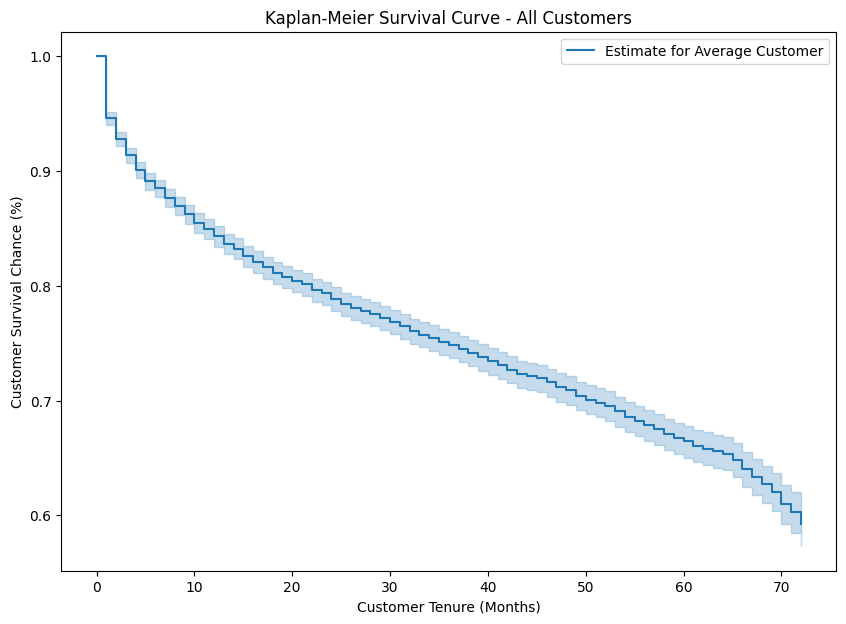

In [17]:
# fitting kmf to churn data
t = churn_data['tenure'].values
churn = churn_data['Churn'].values
kmf = lifelines.KaplanMeierFitter()
kmf.fit(t, event_observed=churn, label='Estimate for Average Customer')

# plotting kmf curve
fig, ax = plt.subplots(figsize=(10,7))
kmf.plot(ax=ax)
ax.set_title('Kaplan-Meier Survival Curve - All Customers')
ax.set_xlabel('Customer Tenure (Months)')
ax.set_ylabel('Customer Survival Chance (%)')
plt.show()

In [18]:
features_to_drop = ['customerID', 'gender', 'PhoneService', 'InternetService']
# engineering numeric columns for Cox Proportional Hazard estimation
churn_hazard = churn_data.drop(features_to_drop, axis=1).copy()

# convert some stuff to integers
churn_hazard['TotalCharges'] = pd.to_numeric(churn_hazard['TotalCharges'], errors='coerce')
churn_hazard['TotalCharges'].fillna(0, inplace=True)

# a lot of variables are encoded as 'Yes' or 'No', lets get these all done at once
binary_features = ['Partner', 'Dependents', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 
                   'StreamingTV','StreamingMovies', 'PaperlessBilling']
for feat in binary_features:
    churn_hazard[feat] = churn_hazard[feat] == 'Yes'
    
# let's one hot encode the remaining categorical features
ohe_features = ['MultipleLines', 'Contract', 'PaymentMethod']
churn_hazard = pd.get_dummies(churn_hazard, 
                              drop_first=True,
                              columns=ohe_features)

In [19]:
cph = lifelines.CoxPHFitter()
cph.fit(churn_hazard, duration_col='tenure', event_col='Churn', show_progress=False)
cph.print_summary()

/Users/seol-yoohwan/.conda/envs/pythonProject/lib/python3.9/site-packages/lifelines/utils/printer.py:62: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return summary_df[columns].to_latex(float_format="%." + str(self.decimals) + "f")


<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn'
      baseline estimation = breslow
   number of observations = 7043
number of events observed = 1869
   partial log-likelihood = -12688.70
         time fit was run = 2022-09-12 11:30:56 UTC

---
                                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                     
SeniorCitizen                           0.03       1.03       0.06            -0.08             0.14                 0.93                 1.16
Partner                                -0.19       0.82       0.06            -0.30            -0.09                 0.74                 0.92
Dependents                             -0.10       0.91       0.07            -0.23             0.04                 0.79                 1.04
OnlineSecurity                         -0.38       0.68       0.07            -0.51            -0.25                 0.60                 0.78
OnlineBackup                           -0.29       0.75       0.06            -0.40            -0.18                 0.67                 0.83
DeviceProtection                       -0.16       0.85       0.06            -0.27            -0.05                 0.76                 0.95
TechSupport                            -0.28       0.76       0.07            -0.41            -0.15                 0.67                 0.86
StreamingTV                            -0.27       0.77       0.06            -0.38            -0.15                 0.68                 0.86
StreamingMovies                        -0.26       0.77       0.06            -0.38            -0.14                 0.69                 0.87
PaperlessBilling                        0.16       1.17       0.06             0.05             0.27                 1.05                 1.31
MonthlyCharges                          0.07       1.07       0.00             0.06             0.07                 1.06                 1.07
TotalCharges                           -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
MultipleLines_No phone service          0.64       1.89       0.12             0.41             0.87                 1.51                 2.38
MultipleLines_Yes                      -0.20       0.82       0.05            -0.30            -0.09                 0.74                 0.91
Contract_One year                      -1.40       0.25       0.10            -1.60            -1.20                 0.20                 0.30
Contract_Two year                      -4.05       0.02       0.20            -4.43            -3.66                 0.01                 0.03
PaymentMethod_Credit card (automatic)  -0.01       0.99       0.09            -0.18             0.17                 0.83                 1.19
PaymentMethod_Electronic check          0.38       1.46       0.07             0.24             0.52                 1.27                 1.69
PaymentMethod_Mailed check              0.52       1.68       0.09             0.35             0.69                 1.42                 1.99

                                        cmp to      z      p   -log2(p)
covariate                                                              
SeniorCitizen                             0.00   0.60   0.55       0.87
Partner                                   0.00  -3.52 <0.005      11.20
Dependents                                0.00  -1.39   0.17       2.60
OnlineSecurity                            0.00  -5.65 <0.005      25.89
OnlineBackup                              0.00  -5.22 <0.005      22.41
DeviceProtection                          0.00  -2.85 <0.005       7.85
TechSupport                               0.00  -4.19 <

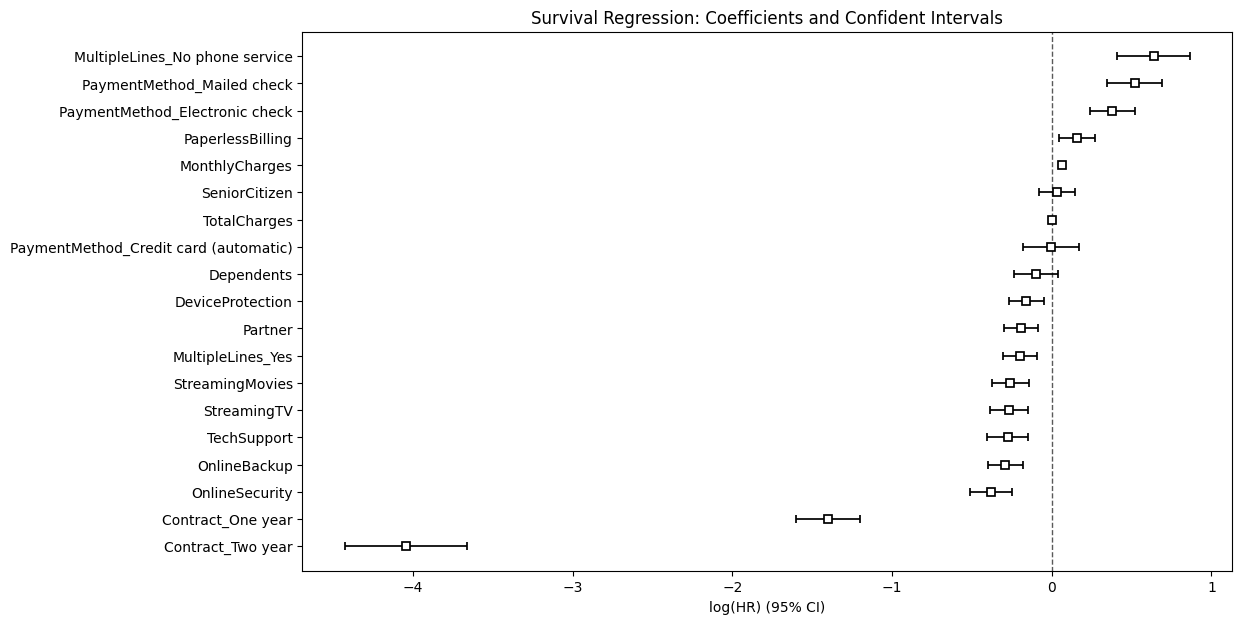

In [20]:
# plotting coefficients
fig_coef, ax_coef = plt.subplots(figsize=(12,7))
ax_coef.set_title('Survival Regression: Coefficients and Confident Intervals')
cph.plot(ax=ax_coef);

In [21]:
# function for creating Kaplan-Meier curve plots segmented
# by categorical variables
def plot_categorical_survival(feature, t='tenure', event='Churn', df=churn_data, ax=None):
    for cat in df[feature].unique():
        idx = df[feature] == cat
        kmf = lifelines.KaplanMeierFitter()
        kmf.fit(df[idx][t], event_observed=df[idx][event], label=cat)
        kmf.plot(ax=ax, label=cat)

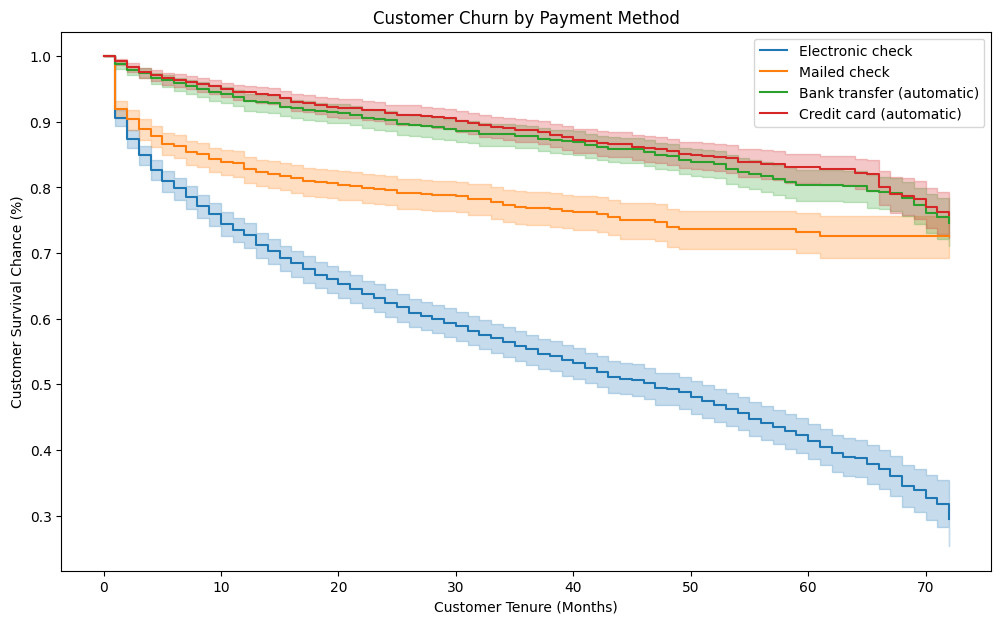

In [22]:
fig_pmt, ax_pmt = plt.subplots(figsize=(12,7))
plot_categorical_survival(feature='PaymentMethod', ax=ax_pmt)
ax_pmt.set_title('Customer Churn by Payment Method')
ax_pmt.set_xlabel('Customer Tenure (Months)')
ax_pmt.set_ylabel('Customer Survival Chance (%)')
plt.show()

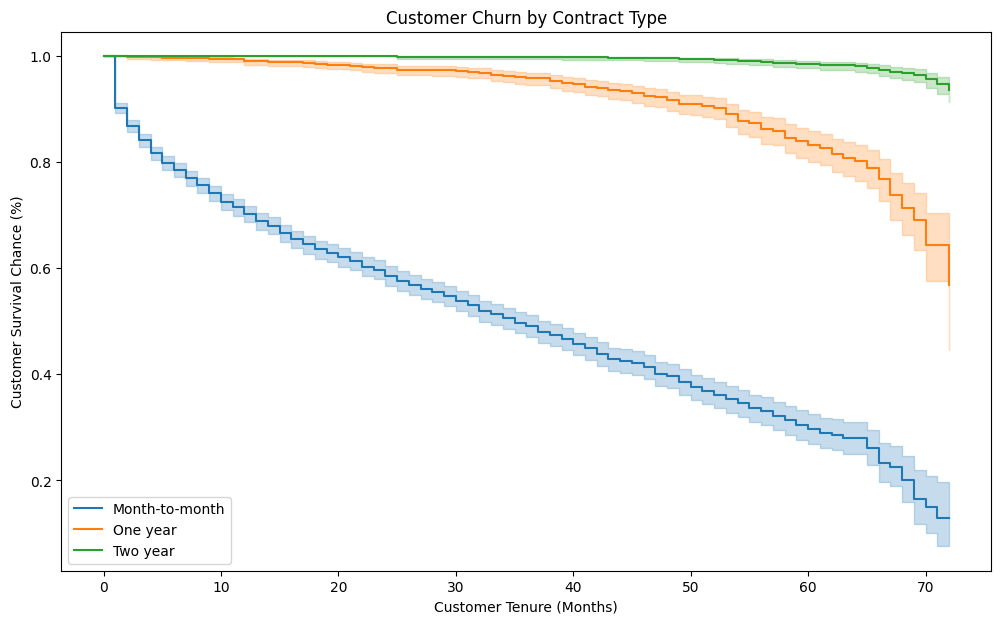

In [23]:
fig_contract, ax_contract = plt.subplots(figsize=(12,7))
plot_categorical_survival(feature='Contract', ax=ax_contract)
ax_contract.set_title('Customer Churn by Contract Type')
ax_contract.set_xlabel('Customer Tenure (Months)')
ax_contract.set_ylabel('Customer Survival Chance (%)')
plt.show()

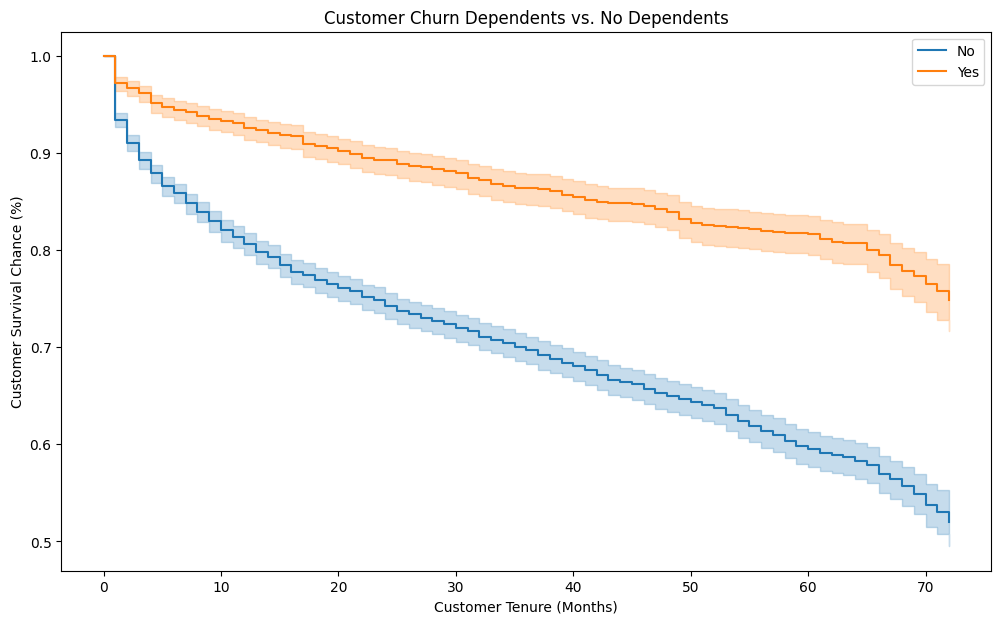

In [24]:
fig_dep, ax_dep = plt.subplots(figsize=(12,7))
plot_categorical_survival(feature='Dependents', ax=ax_dep)
ax_dep.set_title('Customer Churn Dependents vs. No Dependents')
ax_dep.set_xlabel('Customer Tenure (Months)')
ax_dep.set_ylabel('Customer Survival Chance (%)')
plt.show()